In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from mlxtend.plotting import plot_confusion_matrix

seed = (4,2)

2024-07-14 11:11:29.499567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 11:11:29.499672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 11:11:29.621973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.listdir('/kaggle/input/')

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [4]:
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/kaggle/input/HAM10000_metadata.csv')

size = (64, 64)

In [7]:
base_dir = '../input/'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

In [11]:
df = df[['dx', 'image']]

In [12]:
df.head()

dx                                              image
0  bkl  [[[0.7490196078431373, 0.596078431372549, 0.76...
1  bkl  [[[0.09019607843137255, 0.050980392156862744, ...
2  bkl  [[[0.7294117647058823, 0.5058823529411764, 0.5...
3  bkl  [[[0.09411764705882353, 0.043137254901960784, ...
4  bkl  [[[0.5450980392156862, 0.37254901960784315, 0....

In [13]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

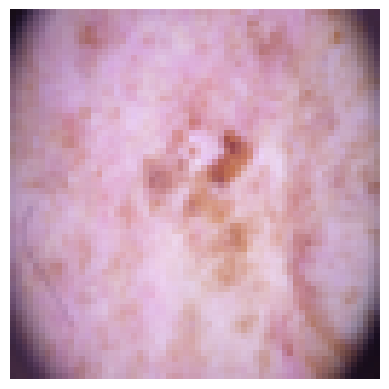

In [14]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off') 
plt.show()

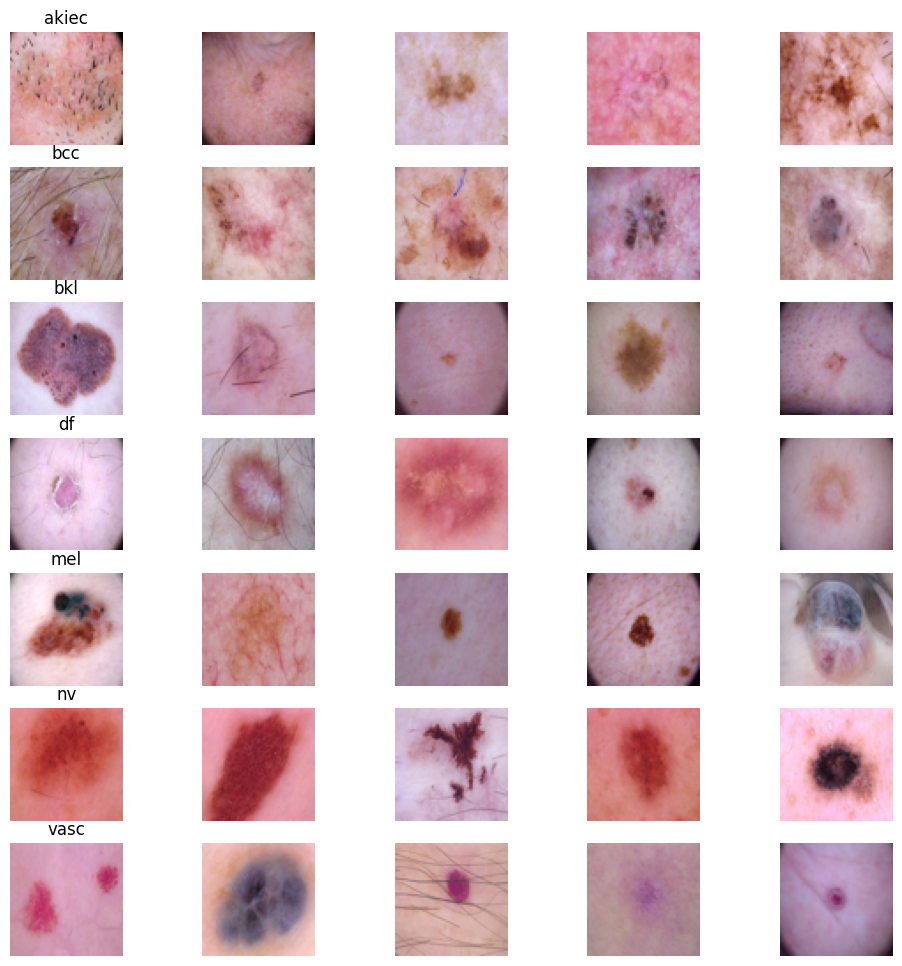

In [15]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [16]:
counts = pd.DataFrame(df['dx'].value_counts()).reset_index()
counts

dx  count
0     nv   6705
1    mel   1113
2    bkl   1099
3    bcc    514
4  akiec    327
5   vasc    142
6     df    115

In [17]:
df_nv = df[df['dx'] == 'nv']

In [19]:
df_df = df[df['dx'] == 'df']

In [20]:
vasc_df = df[df['dx'] == 'vasc']

In [21]:
akiec_df = df[df['dx'] == 'akiec']

In [22]:
bcc_df = df[df['dx'] == 'bcc']

In [23]:
bkl_df = df[df['dx'] == 'bkl']

In [24]:
mel_df = df[df['dx'] == 'mel']

# Data Augmentation

In [25]:
def aug_brightness(img_arr):    
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [26]:
def aug_contrast(img_arr):    
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [27]:
def aug_flip_left_right(img_arr):    
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [28]:
def aug_flip_up_down(img_arr):    
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [29]:
def aug_hue(img_arr):    
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [30]:
def aug_saturation(img_arr):    
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [31]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [32]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))
    
    new_images = pd.DataFrame({'dx': dx, 'image': new_images})
    
    return all_indices, new_images

In [33]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [34]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [35]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [36]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [37]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [38]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [39]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [40]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

dx  count
0     nv   6705
1    mel   2517
2    bkl   2503
3    bcc   1714
4  akiec   1329
5   vasc    844
6     df    817

In [41]:
aug_df.shape

(16429, 2)

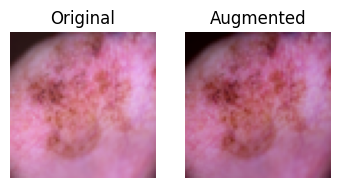

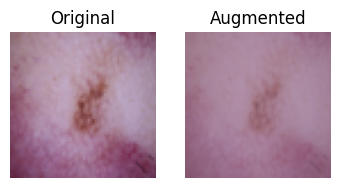

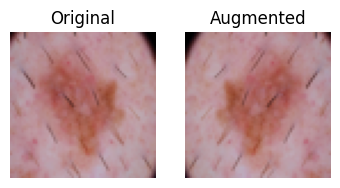

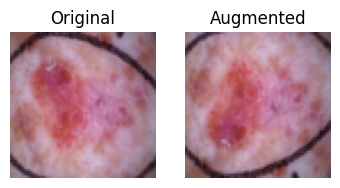

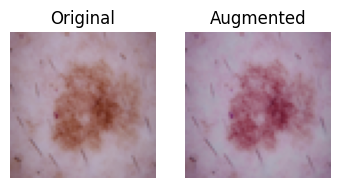

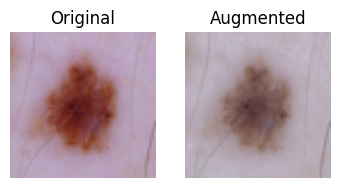

In [42]:
for i in range(12, 18):
    plt.subplot(1, 3, 1) 
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2) 
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')
    
    plt.show()

In [43]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [45]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [46]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count the occurrences of each class in training and testing sets
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
test_counts = pd.Series(y_test_labels).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution:")
print(train_counts)

print("\nTesting Set Class Distribution:")
print(test_counts)

Training Set Class Distribution:
0    1047
1    1345
2    2016
3     662
4    2012
5    5395
6     666
Name: count, dtype: int64

Testing Set Class Distribution:
0     282
1     369
2     487
3     155
4     505
5    1310
6     178
Name: count, dtype: int64


**SMOTE TECHNIQUE**

In [47]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [49]:
# Assuming x_train, y_train, x_test, y_test are already defined
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [50]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)


In [51]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_reshaped, y_train.argmax(axis=1))


In [52]:
x_train_smote = x_train_smote.reshape(x_train_smote.shape[0], 64, 64, 3)
y_train_smote = tf.keras.utils.to_categorical(y_train_smote, num_classes=7)


Training Set Class Distribution After SMOTE:
0    5395
1    5395
2    5395
3    5395
4    5395
5    5395
6    5395
Name: count, dtype: int64


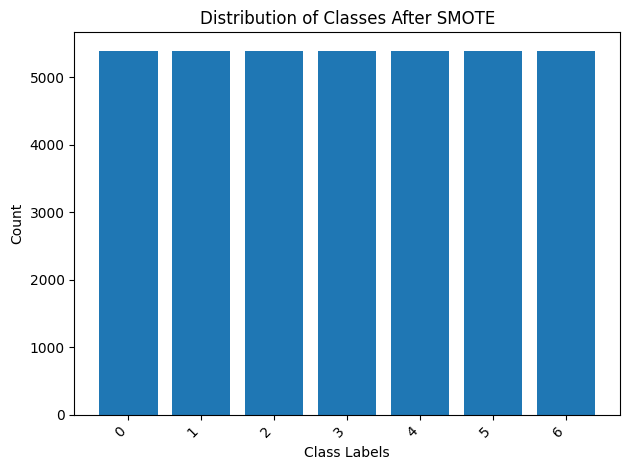

In [53]:
# prompt: i want bar plot of distribution of clases after the SMOTE

import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# ... (Your existing code)

# Count the occurrences of each class after SMOTE
train_counts_smote = pd.Series(y_train_smote.argmax(axis=1)).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution After SMOTE:")
print(train_counts_smote)

# Bar plot of class distribution after SMOTE
plt.bar(train_counts_smote.index, train_counts_smote.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Classes After SMOTE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


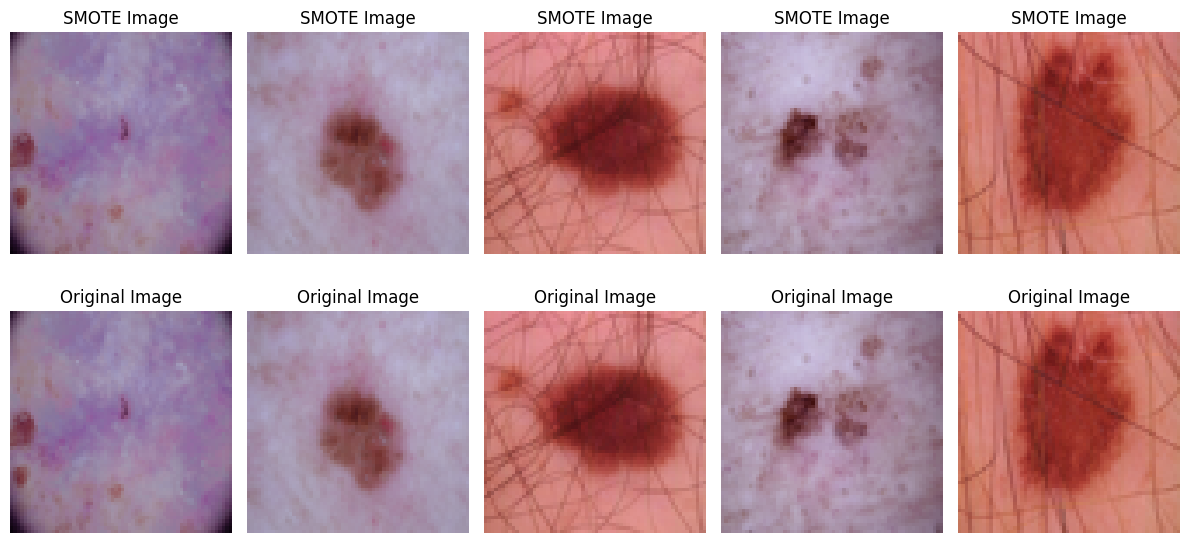

In [54]:
# prompt: print the smote images and the normal images of datset

import matplotlib.pyplot as plt
# Display some SMOTE images and original images for comparison
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize=(12, 6))

# SMOTE Images
for i in range(n_samples):
    m_axs[0, i].imshow(x_train_smote[i])
    m_axs[0, i].set_title('SMOTE Image')
    m_axs[0, i].axis('off')

# Original Images
for i in range(n_samples):
    m_axs[1, i].imshow(x_train[i])
    m_axs[1, i].set_title('Original Image')
    m_axs[1, i].axis('off')

plt.tight_layout()
plt.show()


# Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train_smote, y_train_smote,
                    batch_size=32,
                    epochs=60,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)


Epoch 1/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9669 - loss: 0.0997 - val_accuracy: 0.8506 - val_loss: 0.5398 - learning_rate: 1.0000e-05
Epoch 2/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9689 - loss: 0.0982 - val_accuracy: 0.8558 - val_loss: 0.5304 - learning_rate: 1.0000e-05
Epoch 3/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9690 - loss: 0.0919 - val_accuracy: 0.8564 - val_loss: 0.5298 - learning_rate: 1.0000e-05
Epoch 4/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9680 - loss: 0.0951 - val_accuracy: 0.8536 - val_loss: 0.5408 - learning_rate: 1.0000e-05
Epoch 5/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9729 - loss: 0.0841 - val_accuracy: 0.8576 - val_loss: 0.5467 - learning_rate: 1.0000e-05
Epoch 6/60
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9697 - loss: 0.0931 - val_accuracy: 0.8548 - val_loss: 0.5423 - learning_rate: 1.0000e-05
Epoch 7/60
1181/1181 ━━━━━━━━━━━━━━━━━━━

In [63]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8633 - loss: 0.5047
Test Accuracy: 0.8563603162765503
Test Loss: 0.5298070907592773


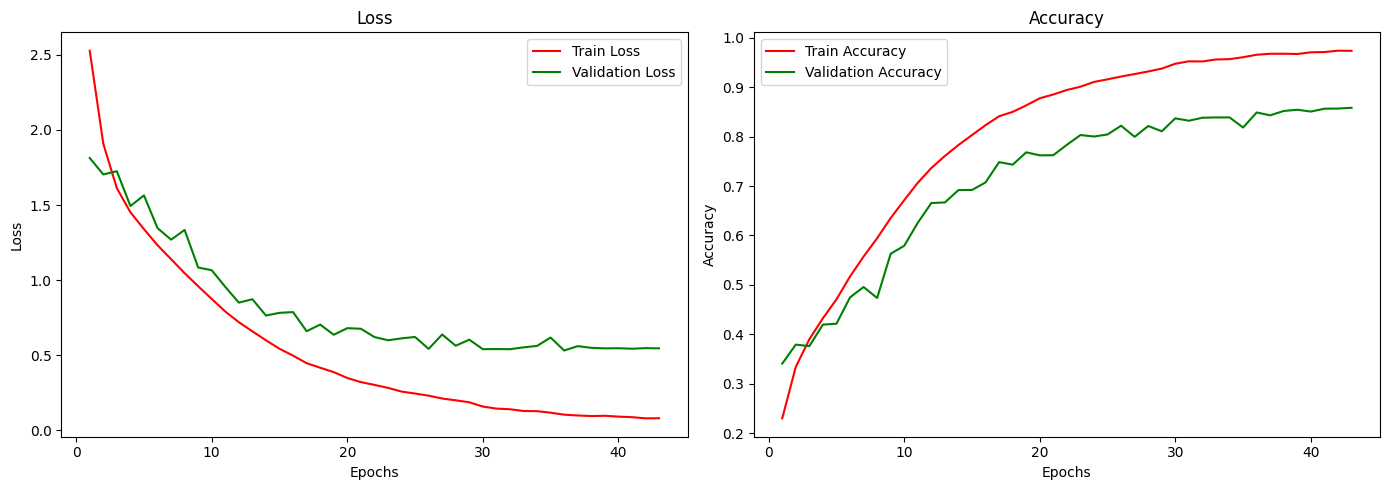

In [61]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

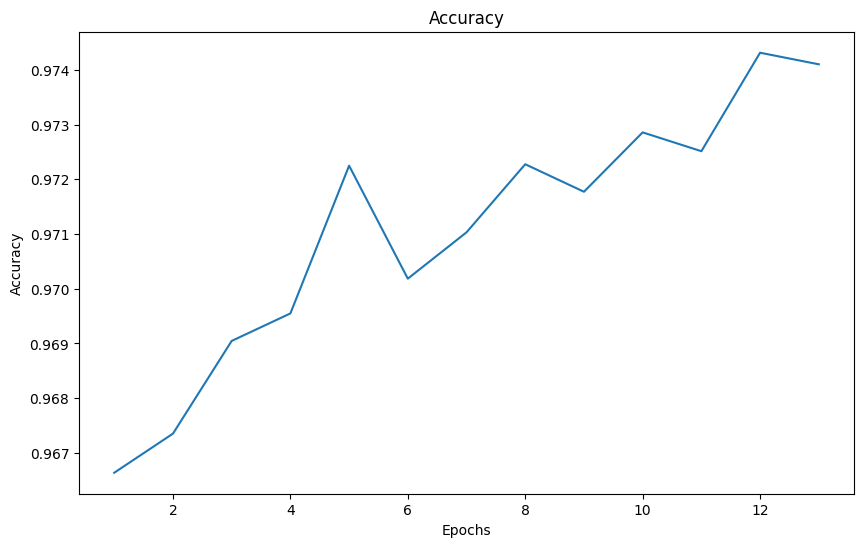

In [64]:
tr_acc = history.history['accuracy']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

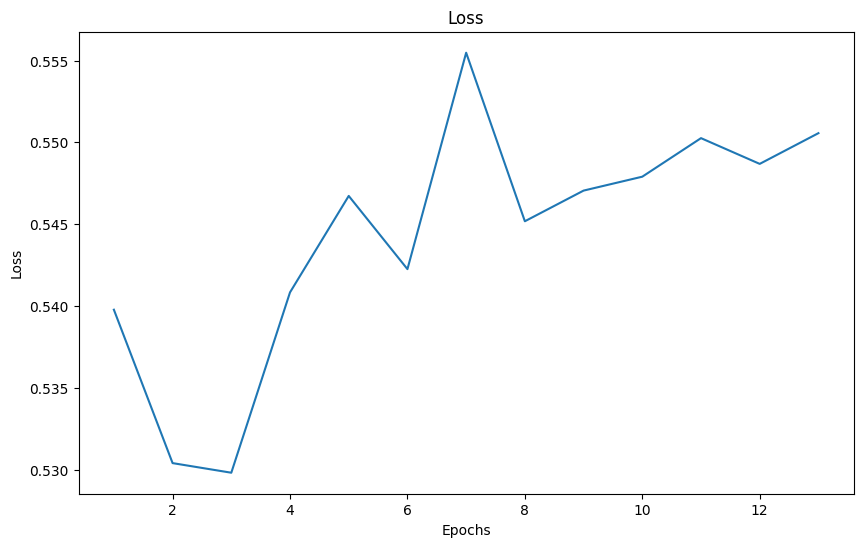

In [65]:
tr_acc = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=50)

In [66]:
#model.save("/kaggle/working/model.h5")

In [67]:
predictions = model.predict(x_test)

 33/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1720958767.471972     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


W0000 00:00:1720958768.792184     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [68]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm

array([[ 257,    8,    6,    0,    8,    3,    0],
       [  19,  316,    9,    7,    7,   10,    1],
       [  18,    9,  390,    4,   33,   33,    0],
       [   0,    1,    0,  150,    2,    2,    0],
       [   9,    6,   39,    2,  379,   70,    0],
       [   9,    9,   51,    4,   82, 1151,    4],
       [   0,    4,    0,    0,    3,    0,  171]])

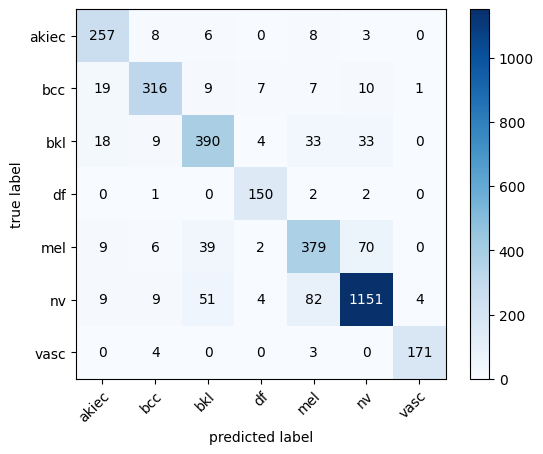

In [69]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=cm_plot_labels, colorbar=True)
plt.show()

In [70]:
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=cm_plot_labels, output_dict=True)

df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.drop(["accuracy", "macro avg", "weighted avg"], inplace=True)
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report["precision"] = df_classification_report["precision"].map(lambda x: round(x, 3))
df_classification_report["recall"] = df_classification_report["recall"].map(lambda x: round(x, 3))
df_classification_report["f1-score"] = df_classification_report["f1-score"].map(lambda x: round(x, 3))
df_classification_report["support"] = df_classification_report["support"].map(int)
df_classification_report

precision  recall  f1-score  support
vasc       0.972   0.961     0.966      178
df         0.898   0.968     0.932      155
nv         0.907   0.879     0.893     1310
bcc        0.895   0.856     0.875      369
akiec      0.824   0.911     0.865      282
bkl        0.788   0.801     0.794      487
mel        0.737   0.750     0.744      505